# Use this notebook if you want to dive into the model and all its functions
Same functions as in Yolov3/darknet.py <br>
Still requires the entire Yolov3/cfg_weights_utils folder

If instead you want an abstracted class for inference, use the Yolov3_as_repo_example.ipynb

In [1]:
import torch
import cv2
import numpy as np
import torch.nn as nn

from matplotlib import pyplot as plt
from Yolov3.cfg_weights_utils.utils import *

%load_ext autoreload
%autoreload 2

In [2]:
def parse_cfg(config_file='./cfg_weights_utils/yolov3.cfg'):
    """ 
    Parse a config file that states the network architecture.
    Official Yolo v3 config can be found online and in ./cfg/yolov3.cfg
    
    Returns a list of dicts, each dict describing a layer in the network
    """
    blocks = []

    with open(config_file) as f:
        # read in all lines, except for empty ones
        lines = [line.rstrip('\n') for line in f if (line.rstrip('\n') != '')]
        # FROM TUTORIAL:
        lines = [x for x in lines if x[0] != '#']              # get rid of comments
        lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces
        
        # skip through first non block lines
        while (lines[0][0] != '['):
            lines = lines[1:]
        
        # while the file is not empty, parse a new block
        i = 0
        while i < len(lines):
            block = {}
            block['type'] = lines[i][1:-1].rstrip()
            i += 1
            while (i < len(lines)) and (lines[i][0] != "["):
                key, val = lines[i].split('=')
                block[key.rstrip()] = val.lstrip()             # rstrip() + lstrip() FROM TUTORIAL
                i +=1
            blocks.append(block)
        
        # seperate out first non-layer block (network meta info)
        net_info = blocks[0]
        
    return net_info, blocks[1:]

In [3]:
def create_modules(blocks):
    # init
    mod_list = nn.ModuleList()       # This list will contain all our layers
    in_features = 3                  # Previous layer's # output channels (3 for RGB)
    out_features = []                # keep track of each layers # output channels
    
    for idx, block in enumerate(blocks):
        if block['type'] == 'convolutional':
            mod_list.append(create_conv_layer(block, in_features, idx))
            out_features.append(int(block['filters']))
            in_features = out_features[-1]
            
        elif block['type'] == 'upsample':
            mod_list.append(create_upsample_layer(block, idx))
            out_features.append(out_features[-1])
        
        elif block['type'] == 'route':
            mod_list.append(create_route_layer(block, idx))
            out_feature = sum([out_features[int(i)] for i in block['layers'].split(',')])
            out_features.append(out_feature)
            in_features = out_features[-1]
        
        elif block['type'] == 'shortcut':
            mod_list.append(create_shortcut_layer(block, idx))
            out_features.append(out_features[-1])
        
        elif block['type'] == 'yolo':
            mod_list.append(create_detection_layer(block, idx))
            out_features.append(out_features[-1])
    
        else:
            raise ValueError('Block type note recognised/implemented: {}'.format(block['type']))
    
    return mod_list

In [4]:
class Darknet(nn.Module):
    def __init__(self, config_file='./Yolov3/cfg_weights_utils/yolov3.cfg',
                        class_file='./Yolov3/cfg_weights_utils/coco.names'):
        
        super(Darknet, self).__init__()
        self.class_names           = load_classes(class_file)
        self.net_info, self.blocks = parse_cfg(config_file)
        self.module_list           = create_modules(self.blocks)
        
    def forward(self, x, gpu_enabled=False):
        # store the current image's resolution
        self.net_info['height'], self.net_info['width'] = x.shape[-2:]
        
        outputs = {}               # store all activation outputs to be accessed by routing and shortcuts
        bboxes  = torch.empty(0)   # concatenate all bbox predictions to this initially empty tensor
        
        # process all modules in order
        for i, block in enumerate(self.blocks):
            
            # convolutional or upsample layer
            if block['type'] in ['convolutional', 'upsample']:
                x = self.module_list[i](x)
                outputs[i] = x
            
            # shortcut layer
            elif block['type'] == 'shortcut':
                frm = i + int(block['from'])
                x.add_(outputs[frm])
                outputs[i] = x
            
            # route layer
            elif block['type'] == 'route':
                layers = [int(layer) for layer in block['layers'].split(',')]     # get layers as int in a list
                layers = [layer if (layer > 0) else i+layer for layer in layers]   # make all layers absolute
                if len(layers) == 1:
                    x = outputs[layers[0]]
                elif len(layers) == 2:
                    x = torch.cat((outputs[layers[0]], outputs[layers[1]]), dim=1) # concatenate layers if more than 1
                else:
                    ValueError('Routing with more than 2 ({}) layers not implemented'.format(layers))
                
                outputs[i] = x
            
            # detection layer
            elif block['type'] == 'yolo':
                input_size  = self.net_info['width']
                anchors     = self.module_list[i][0].anchors
                num_classes = int(block['classes'])
                
                preds       = predict_transform(x, input_size, anchors, num_classes)
                bboxes      = torch.cat((bboxes, preds), dim=1)
            
            else:
                raise ValueError('Block type note recognised/implemented: {}'.format(block['type']))
                
        return bboxes
    
    def load_weights(self, weights_file='./Yolov3/cfg_weights_utils/yolov3.weights'):
        # importing the weights seems extremely tedious.
        # definitely couldn't have done it without the tutorial stating the order and datatype
        # weights are stored in the order: batch_norm or bias, weights
        # bn weights are stored in the order: bias, weight, running_mean, running_var
        
        # get weights from file
        with open(weights_file) as f:
            # FROM TUTORIAL
            _ = np.fromfile(f, dtype=np.int32, count=5)  # overhead
            weights = np.fromfile(f, dtype=np.float32)   # all conv and batch norm weights
        
        # check all modules in order
        i_w = 0
        for block, module in zip(self.blocks, self.module_list):
            
            # only conv layers carry weights
            if block['type'] != 'convolutional':
                continue
            
            # get a list of tensors whose weights are stored for the current layer
            # check whether conv layer includes batch norm, if not it contains a bias (below)
            if int(block.get('batch_normalize', 0)):
                weight_tensors = [module[1].bias,          # batch norm bias
                                  module[1].weight,        # batch norm weight
                                  module[1].running_mean,  # batch norm running mean
                                  module[1].running_var,   # batch norm running variance
                                  module[0].weight]        # conv weights
            else:
                weight_tensors = [module[0].bias,          # conv bias
                                  module[0].weight]        # conv weights
            
            # load in weights for current list of weight_tensors
            for tensor in weight_tensors:
                data        = weights[i_w:i_w+np.prod(tensor.shape)]
                tensor.data = torch.tensor(data).view_as(tensor)
                i_w        += np.prod(tensor.shape)        
        
        # assert on finish we used all weights
        assert i_w==len(weights), 'Error: Not all weights from {} have been used,' \
                                  ' {} unaccounted for.'.format(weights_file, len(weights)-i_w)
                

In [5]:
def get_detections(pred, obj_confidence, nms_confidence, class_names):
    # map all predictions to true detections via Non Maximum Suppression (NMS)
    # manipulation of pred is partly done in place,
    # so probably better to pass either a copy or to .detach() pred
    
    pred[:,:,:4] = pred2corners(pred[:,:,:4])        # first map pred coordinates into corners -> pred[:,:,:4]
    pred[:,:,5], pred[:,:,6] = pred[:,:,5:].max(2)   # get max val in pred[:,:,5] and argmax in pred[:,:,6]
    true_dets_batch = []                             # output with true detection dict for each batch item
    
    ### handle each image separately
    for b in range(pred.shape[0]):
        class_dets      = {}                         # empty dict of class separated detections

        for pr in range(pred[b].shape[0]):           # loop through each prediction
            
            if pred[b, pr, 4] < obj_confidence:      # discard predictions with p_objectness < obj_confidence
                continue
            cls = class_names[int(pred[b, pr, 6].item())]
            if (cls in class_dets):
                class_dets[cls] = torch.cat((class_dets[cls], pred[b, pr:pr+1, :7]), dim=0)
            else:
                class_dets[cls] = pred[b, pr:pr+1, :7]
        
        ### actual NMS
        # class_det now has class-sorted (>confidence) predictions
        # (which we now call detections). Now perform the actual NMS:
        for cls, dets in class_dets.items():
            # keep a mask of all left over detections
            dets_mask = [i for i in range(dets.shape[0])]
            true_dets = torch.empty(0)
            
            while (len(dets_mask) > 0):
                # get max prob detection (based on objectness score=4 or class score=5?)
                _, true_i = dets[:, 4].max(0)
                true_dets = torch.cat((true_dets, dets[true_i:true_i+1, :]), dim=0)
                dets[true_i, 4] = -1
                dets_mask.pop(dets_mask.index(true_i))
                
                # discard all detections with an IoU > nms_confidence (with true_det)
                # This part can be optimized still into calculating all IoU's at the same time
                for i in reversed(dets_mask):
                    if (IoU(dets[true_i, :4], dets[i, :4]) >= nms_confidence):
                        dets[i, 4] = -1
                        dets_mask.pop(dets_mask.index(i))
            
            # once done, replace the class_dets item for the current class with true detections
            class_dets[cls] = true_dets
        
        # once done with all the classes for the current image, append the result to the final output list
        true_dets_batch.append(class_dets)
            
    return true_dets_batch

In [6]:
class YOLOv3:
    """
    abstraction/wrapper function for pipelines and the darknet / yolov3 model
    simplest (and currently only) use case is to run .inference()
    
    input:  raw numpy image, BGR, int values in [0, 255]
    output: image copy with annotated detections, BGR
    """
    def __init__(self):
        self.model = Darknet()
        self.model.load_weights()
        
    def inference(self, img, obj_confidence=0.5, nms_confidence=0.4):
        img_input, offset = ImgUtils.preprocess(img.copy())
        
        # actual inference
        predictions       = self.model(img_input)
        detections_dict   = get_detections(predictions,
                                           obj_confidence=obj_confidence,
                                           nms_confidence=nms_confidence,
                                           class_names=self.model.class_names)
        
        # currently implementation includes batches but only 1 image per batch
        detections_dict   = detections_dict[0]
        
        # print out all detected classes plus their # of instance
        # for cls, detection in detections_dict.items():
        #     print(cls, detection.shape[0])
        ann_img           = ImgUtils.annotate_img(img, offset, detections_dict)
        
        return ann_img

In [7]:
def show(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

(452, 602, 3)


/Users/anner/Code/miniconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/Users/anner/Code/miniconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


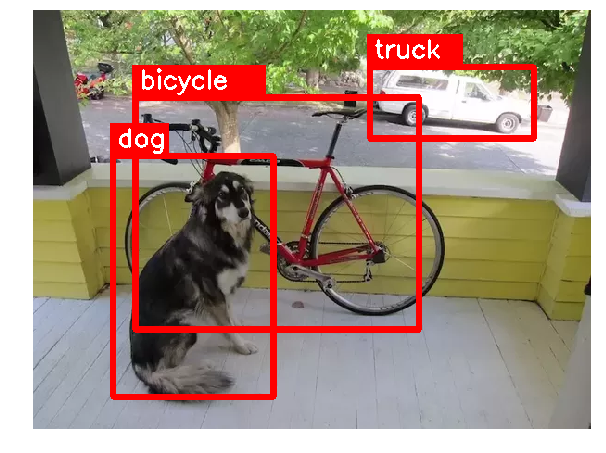

(576, 768, 3)


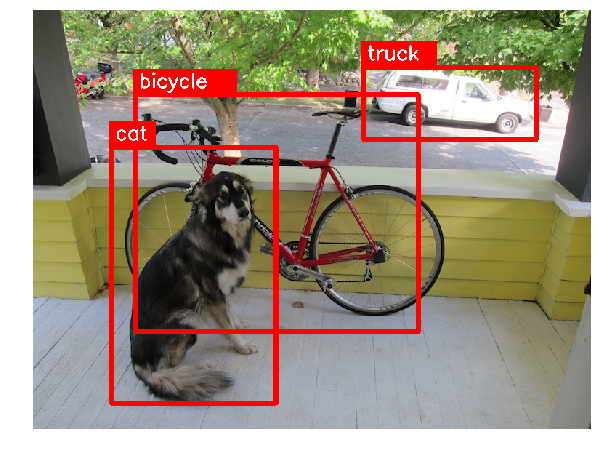

In [8]:
yolo    = YOLOv3()

# image from Ayoosh Kathuria (https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch)
img     = cv2.imread('dog-cycle-car.png')
print(img.shape)
ann_img = yolo.inference(img)
show(ann_img[:, :, ::-1])

# Interestingly enough, the same picture (but different format)
# taking from the original repository renders a worse detection result
# image from Joseph Redmon (https://github.com/pjreddie/darknet)
img     = cv2.imread('dog.jpg')
print(img.shape)
ann_img = yolo.inference(img)
show(ann_img[:, :, ::-1])